## Zadanie domowe - Algorytm Canny'ego

Celem zadania domowego jest wykonanie pełnej implementacji algorytmu Canny'ego.

W ramach ćwiczenia w trakcie laboratorium wyznaczono obrazy $g_{NH}$ i $g_{NL}$.
Dla przypomnienia:
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Wykorzystuje się więc krawędzie "potencjalne", aby uzupełnić nieciągłości.
Procedura wygląda następująco:
1. Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
2. Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
3. Stwórz obraz, który zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
4. Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź, czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź.
        Można to wykonać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.
8. Porównaj wynik algorytmu z wynikiem OpenCV.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować w bardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj pełny algorytm Canny'ego.

In [34]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

if not os.path.exists("dom.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png --no-check-certificate

I = cv2.imread("dom.png", cv2.IMREAD_GRAYSCALE)

def nonmax(k, a):
    result = np.zeros(k.shape)
    for i in range(1, k.shape[0] - 1):
        for j in range(1, k.shape[1] - 1):

            if (22.5 < k[i, j] < 67.5) or (-22.5 > k[i, j] > -67.5):
                if a[i, j] >= a[i - 1, j + 1] and a[i, j] >= a[i + 1, j - 1]:
                    result[i, j] = a[i, j]
            
            elif (157.5 > k[i, j] > 112.5) or (-112.5 > k[i, j] > -157.5):
                if a[i, j] >= a[i + 1, j + 1] and a[i, j] >= a[i - 1, j - 1]:
                    result[i, j] = a[i, j]
            
            elif (-67.5 > k[i, j] > -112.5) or (67.5 < k[i, j] < 112.5):
                if a[i, j] >= a[i + 1, j] and a[i, j] >= a[i - 1, j]:
                    result[i, j] = a[i, j]

            elif (22.5 > k[i, j] > -22.5) or (157.5 < k[i, j] < 180) or (-180 < k[i, j] < -157.5):
                if a[i, j] >= a[i, j - 1] and a[i, j] >= a[i, j + 1]:
                    result[i, j] = a[i, j]

    return result


def full_canny_algorithm(img, size, sigma, TL, TH):
    result = np.zeros(shape=img.shape)
    stack = []
    visited = []

    gauss = cv2.GaussianBlur(img, (size, size), sigma)
    gx = cv2.Sobel(gauss, cv2.CV_32F, 1, 0, 3)
    gy = cv2.Sobel(gauss, cv2.CV_32F, 0, 1, 3)
    M = (gx**2 + gy**2)**(1/2)
    alfa = np.arctan2(gy, gx)
    alfa = np.rad2deg(alfa)
    gn = nonmax(alfa, M)

    g_nh = ((gn >= TH)*255).astype('uint8')
    g_nl = (((gn >= TL) & (gn < TH))*255).astype('uint8')

    for i in range(g_nh.shape[0]):
        for j in range(g_nh.shape[1]):
            if g_nh[i, j] != 0:
                stack.append([i, j])

    while stack != []:
        pix = stack.pop()
        i = pix[0]
        j = pix[1]
        if pix not in visited:
            visited.append(pix)
            result[i, j] = 255
            for k in range(i - size//2, i + size//2+1):
                for l in range(j - size//2, j + size//2+1):
                    if g_nl[k, l] != 0:
                        stack.append([k, l])

    return g_nh, result


def disp_canny(img, size=3, sigma=0, TL=10, TH=240):
    g_nh, result = full_canny_algorithm(img, size, sigma, TL, TH)

    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(24, 6)
    ax[0].imshow(img, 'gray', vmin=0, vmax=256)
    ax[0].axis("off")
    ax[0].set_title("Obraz oryginalny")

    ax[1].imshow(g_nh, 'gray')
    ax[1].axis("off")
    ax[1].set_title("g_nh")

    ax[2].imshow(result, 'gray')
    ax[2].axis("off")
    ax[2].set_title("Obraz wynikowy")

    ax[3].imshow(cv2.Canny(img, 80, 240, None, 3, 1), 'gray')
    ax[3].axis("off")
    ax[3].set_title("cv2")

    plt.show()

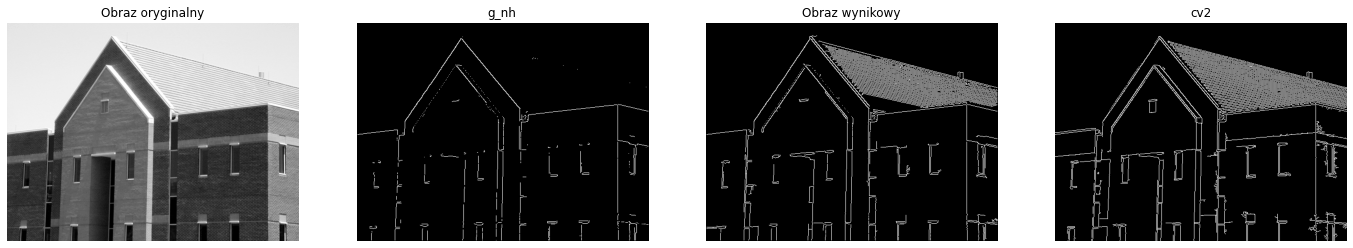

In [35]:
disp_canny(I)

Obecna wersja Canny działa znacznie lepiej niż poprzednia 'niepełna', jednak mimo to widać, że czegoś jej brakuje w stosunku do wbudowanej funkcji openCV - nie zostały wychwycone niektóre dachówki, mniej wyraźne krawędzie okien, a także pasy na elewacji budynku. Więcej krawędzi można uzyskać manipulując parametrami TH oraz TL. Dla obecnych ustawień wynoszą one odpowiednio 240 i 10, co wprawdzie łamie zasadę stosunku 1:3, jednak daje lepsze rezultaty.